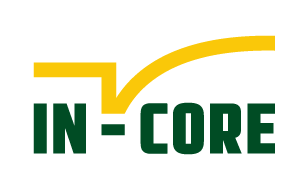


# Pole-Building Assignment

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path
import networkx as nx

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.5.2
numpy version:  1.24.1


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Users\\Kooshan\\Box\\Rice\\Software_Projects\\Pycharm\\IN-CORE_Galveston\\jupyter_book\\notebooks\\03_AdditionalNotebooks\\Nearest neighbor analysis_Poles and Buildings'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [5]:
path_to_output = os.path.join(os.getcwd(), 'output',)
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

## Poles-Buildings matching

In [6]:
# Buildings geopandas
bldg_dataset_id = "60354b6c123b4036e6837ef7"                    # defining building dataset (GIS point layer)       
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
bldg_df = bldg_dataset.get_dataframe_from_shapefile()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [7]:
# Poles geopandas
Galv_WoodPoles_df = gpd.read_file('Galv_WoodPoles.shp')
Galv_PrestressedPoles_df = gpd.read_file('Galv_PrestressedPoles.shp')
Galv_Poles_df = gpd.GeoDataFrame( pd.concat( [Galv_WoodPoles_df, Galv_PrestressedPoles_df], ignore_index=True) )

### Let’s also make maps out of them to get a better understanding of the data

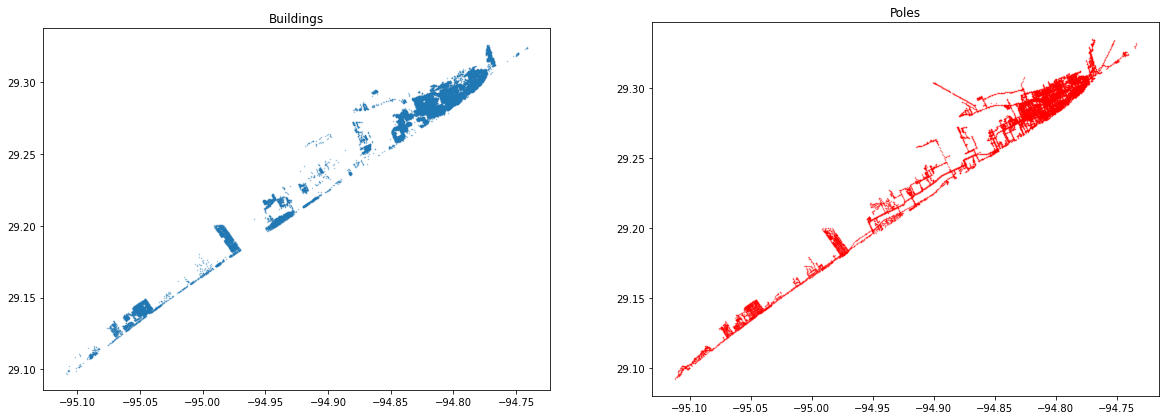

In [8]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
bldg_df.plot(ax=axes[0],markersize=0.2, alpha=0.5)
axes[0].set_title('Buildings')

# Plot poles
Galv_Poles_df.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('Poles');

### we can see from the coordinates and the map that both of the layers share the same coordinate reference system. Hence, we are ready to find closest pole (on the right) for each building on the left map. Let’s first prepare a couple of functions that does the work

In [9]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

### Okay, now we have our functions defined. So let’s use them and find the nearest neighbors!

In [10]:
# Find closest pole for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_poles = nearest_neighbor(bldg_df, Galv_Poles_df, return_dist=True)

# And the result looks like ..
closest_poles

,OBJECTID,LON,LAT,CLASS,HEIGHT,TYPE,SpanLength,geometry,distance
0,81,-94.920949,29.227509,5,20,1,44.339908,POINT (-94.92095 29.22751),12.972083
1,83,-94.920726,29.227814,5,20,1,12.173564,POINT (-94.92073 29.22781),8.944374
2,93,-94.921127,29.228522,5,20,1,31.155735,POINT (-94.92113 29.22852),9.022716
3,80,-94.921431,29.227216,5,20,1,65.903857,POINT (-94.92143 29.22722),8.771394
4,80,-94.921431,29.227216,5,20,1,65.903857,POINT (-94.92143 29.22722),4.127933
...,...,...,...,...,...,...,...,...,...
18957,115,-94.923173,29.228940,5,20,1,59.423983,POINT (-94.92317 29.22894),8.052183
18958,94,-94.923030,29.228031,5,20,1,76.323221,POINT (-94.92303 29.22803),15.670623
18959,114,-94.922666,29.229132,5,20,1,79.698817,POINT (-94.92267 29.22913),11.465839
18960,76,-94.922322,29.226667,5,20,1,27.425693,POINT (-94.92232 29.22667),16.658708


In [11]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(len(closest_poles), '==', len(bldg_df))

18962 == 18962


In [12]:
closest_poles_to_bldgs = pd.merge(bldg_df[["guid","geometry"]], closest_poles, left_index=True, right_index=True)

In [13]:
result_name = os.path.join(path_to_output, 'closest_poles_to_bldgs')

In [15]:
closest_poles_to_bldgs.to_csv(result_name+'.csv')